# Neural network training


### Architecture decision
It is not easy to came up with working architecture out of blue. ML is highly empirical process.

Define the problem and look for existing architectures, nice site is for example here https://paperswithcode.com/ or https://arxiv.org/

Many problems were already solved or the coud by some model from other domain that appears to fit nicely in your domain (ResNet in audio).

One of study could be FaceNet https://arxiv.org/abs/1503.03832

If we go through the paper we will find they used triplets and this architecture for feature extractor.
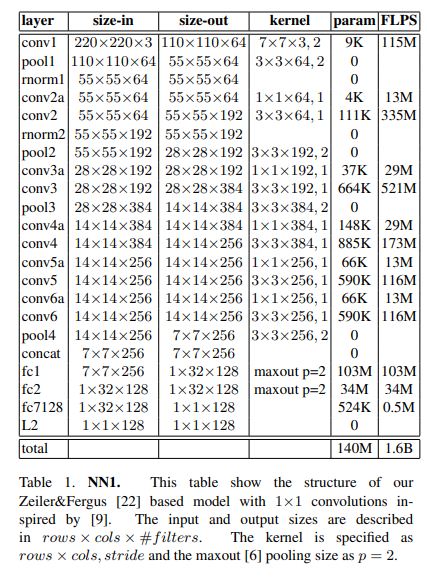

There is also a note they successfully used GoogLeNet architecture.

### Making adjustments
We don't want to waste time and resources for training on huge set of data architecture that has not been proven.
#### Transfer learning
We can see the convolutional part are image classification networks in both cases. We could:
* try to find pre-trained used models
* use different pre-trained architecture - that may not be even invented during the time of study publishing
* if you cannot find model trained exactly for your case, fine tune the pre-trained model or train only a few upper levels in case of using CNN architectures like a ResNet

#### Test the model
Try existing model, how it works on your data in case.

Train on a small sample of images to see if model is able to train.

If it does and overfit, you are at the good start!

### Tuning of the model
If you have a promising architecture, you can train on bigger set of data and try to adjust hyperparametrs based on the model performance.

Deep learing is an iterative process and you should always tune just a single hyperparametr at the time co you can get better understaning of it.

## Loss function progress
Basic diagnosis of model can by done by looking at the loss function progress.
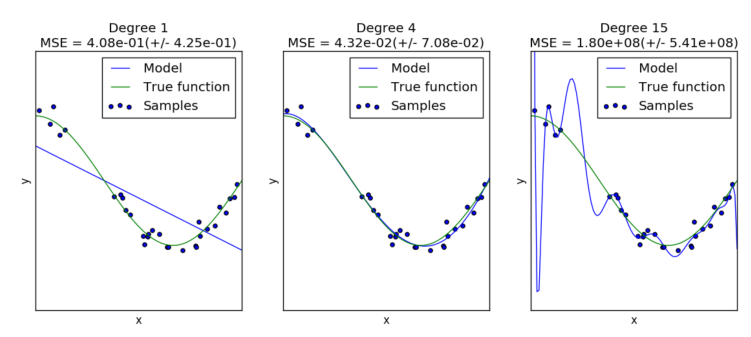
https://www.researchgate.net/publication/332412613

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

Downloading dataset from web.

https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [ ]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
COLUMN_NAMES = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(
    URL,
    names=COLUMN_NAMES,
    na_values='?',
    sep=' ',
    comment='\t',
    skipinitialspace=True)

Remove empty record with empty values from data.

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset

Split data for test and training set and shuffle them.

In [ ]:
train_dataset = dataset.sample(frac = 0.8, random_state = 42)
test_dataset = dataset.drop(train_dataset.index)

Define labels - miles per galon.

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

We want to standardize data - data will have mean = 0 and the standard deviation = 1.

In [ ]:
def standardize(data):
    return (data-data.mean())/data.std()

In [ ]:
train_features = standardize(train_dataset)
test_features = standardize(test_dataset)

In [ ]:
train_features

## Underfit

Model has problems to fit the data. It is either too simple or need longer training.

* Bigger network
* Train longer
* Look for proven architectures

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(1, activation='relu')(input_layer)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

Use simple model and train for a short time.

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=100)

When you see validation loss giving better results then train one, it could mean:
* you are using some kind of regularization (later in this notebook)
* training loss is calculated during the epoch, but the validation set is evaluated on the end of the epoch where model was already trained on the whole set
* just a coincidence that sampled data for validation set fits better 😊

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

## Balanced

Ideal state when validation loss is close to the training and we are having acceptable error.

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

Using balanced model.

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=700)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,20)
plt.legend()
plt.grid(True)

## Overfitting

Network tries to fit on noise.

Loss is getting worse over the time.

* More data
* Simpler architecture
* Early stopping
* Look for proven architectures
* Regularization

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(128, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

Using complex model.

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=700)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,10)
plt.legend()
plt.grid(True)

## Regularization techniques

Set of techniques preventing model to overfit.

One is to reduce number of layers/units in layers, or augment the data. 

Others most common are:

### Dropout
Sets the probability to "drop down" neuron of current layer on every step of training.
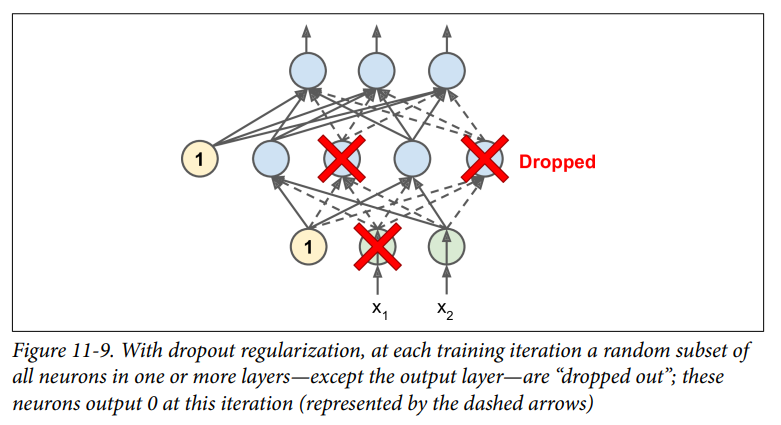
Neurons needs to learn to be more general, they cannot directly rely just on selected others.
Also makes them less sensitive to slight changes in inputs. 

In [ ]:
# set probability for neuron to be dropped - value is set to 0
tf.keras.layers.Dropout(rate=0.3)

Dropout is active only during training, so loss function may look weird.

It is important to evaluate model after training to get the real perfomance!

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(128, activation='relu')(input_layer)
x = tf.keras.layers.Dropout(0.05)(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

Using complex but with dropping 5% of neurons.

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=700)

In [ ]:
# plot loss function on training set
plt.plot(history.history['loss'], label='loss')
# plot loss function on validation set
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,10)
plt.legend()
plt.grid(True)

## $\ell_1$ and $\ell_2$ regularization

Penalizes loss function using model complexity to encourage small weights of neurons.

If we are having huge weights then even small changes in inputs can result in big changes in the output which is sign of overfitting.

It is important to standardize data before using $\ell_1$ and $\ell_2$ regularization. It will not work well if data scales differs.

Introduces new hyperparameter $\lambda$


### $\ell_1$ regularization

Every time subtracts little bit of weight values till it reaches 0 for uninformative features. 

Shring less important features - creates sparse output -> more 0, that works like a simpler model.

$Loss = Error(y, \hat y) + \lambda\sum_{i=1}^{N}|w_i| $

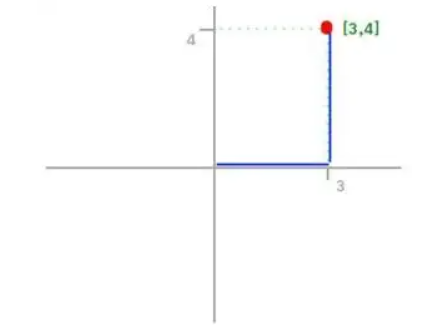

https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c

In [ ]:
from tensorflow.keras import regularizers
tf.keras.layers.Dense(units=16, kernel_regularizer=regularizers.L1(1e-5))

### $\ell_2$ regularization

More popular.

Forces weights to zero, but is never exactly zero.

$Loss = Error(y, \hat y) + \lambda\sum_{i=1}^{N}||w_i||^2 $

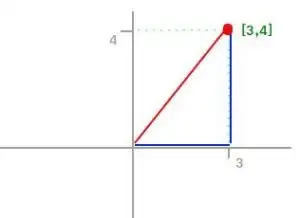

How this works?

$dw^{[i]} = (\text{from backpropagation}) + \lambda w^{[i]} $

$w^{[i]} = w^{[i]} - \alpha dw^{[i]}$

$w^{[i]} = w^{[i]} - \alpha [ (\text{from backpropagation}) + \lambda w^{[i]}]$

$w^{[i]} = w^{[i]} - \alpha\lambda w^{[i]} - \alpha(\text{from backpropagation})$

In [ ]:
tf.keras.layers.Dense(units=16, kernel_regularizer=regularizers.L2(1e-5))

It is possible to use both types of $\ell$ regularization.

In [ ]:
tf.keras.layers.Dense(units=16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))

## Learning rate

One of the most important hyperparameters.

Sets the weights update rate.

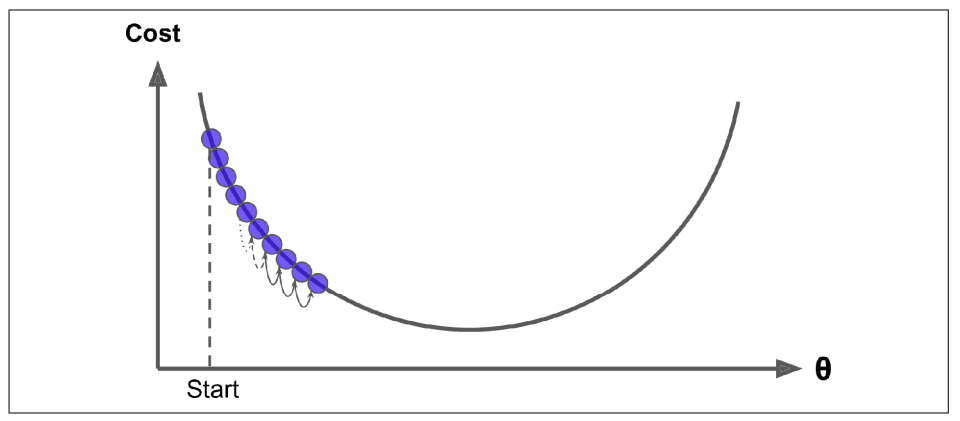

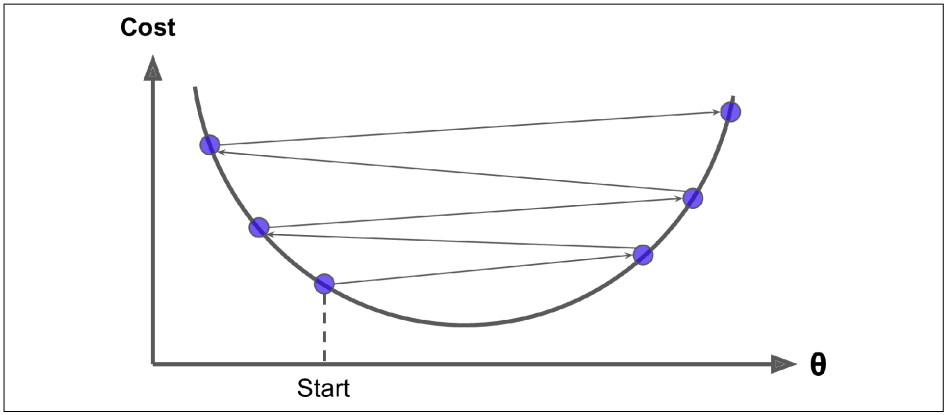

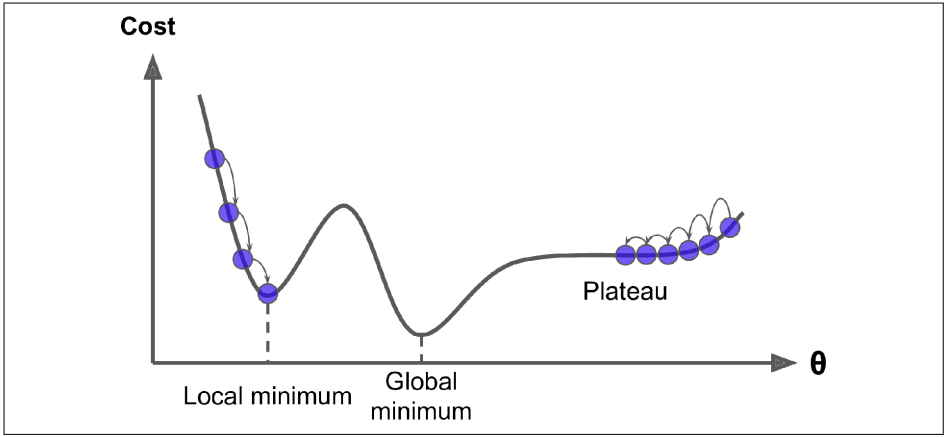

Influence of different learning rates on model performance.

**SGD lr=0.01**

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history_001 = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=300)

Too high learning rate - unstable loss function, has dificulties to converge to a minimum.

In [ ]:
plt.plot(history_001.history['loss'], label='loss')
plt.plot(history_001.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,10)
plt.legend()
plt.grid(True)

**SGD lr=0.001**

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

history_0001 = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=300)

In [ ]:
plt.plot(history_0001.history['loss'], label='loss')
plt.plot(history_0001.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,10)
plt.legend()
plt.grid(True)

**SGD lr=0.0001**

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001))

history_00001 = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=300)

In [ ]:
plt.plot(history_00001.history['loss'], label='loss')
plt.plot(history_00001.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0,10)
plt.legend()
plt.grid(True)

**SGD lr=0.000001**

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(32, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001))

history_0000001 = model.fit(
    train_features,
    train_labels,
    batch_size = 16,
    validation_split=0.2,
    verbose=1, 
    epochs=300)

With such a small rate the model almost fail to converge.

In [ ]:
plt.plot(history_0000001.history['loss'], label='loss')
plt.plot(history_0000001.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

## Other techniques improving training
### Minibatches
Minibatch sets how many samples from the set will be used for forward propagation before computing an error.
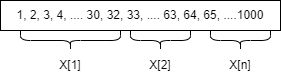

Bigger batches leads to faster training, however, they are also more demanding on computer memory and could introduce instabilities.



Typical setting is power of 2 - 8, 16, 32, 64...

Keras default to 32, that is good starting point.

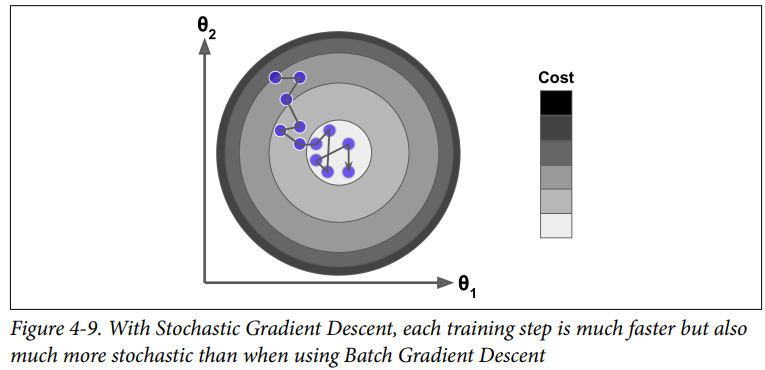

In [ ]:
history = model.fit(train_features, train_labels, batch_size = 16)

## Batch normalization
Zero centers and normalize inputs for each batch - the same as standardization does.

For each  batch:
* calculate mean value for current minibatch: $ \mu = {1\over m}\sum_{i=1}^{m}x^{(i)}$


* calculate standard deviation for current minibatch: $ \sigma^2 = {1\over m}\sum_{i=1}^{m}(x^{(i)} - \mu)$


* get standardized output: $ \hat{x}^{(i)} = {{x^{(i)}-\mu}\over \sqrt{\sigma^2 + \epsilon}}$

* set scaling and shifting (it can map identity function if $ \gamma = \sqrt{\sigma^2 + \epsilon} $ and $ \beta = \mu $):

$ a^{(i)}= \gamma * \hat{x}^{(i)} + \beta $ 

Where:
* $ \mu $ is mean 
* $ \sigma $ is standard deviation 
* $ m $ number of instances in the minibatch
* $ \gamma $ is the scale parameter for standardized output - **learnable parameter**
* $ * $ element-wise multiplication
* $ \beta $ output shift/offset - **learnable parameter**
* $ \epsilon $ tiny number avoiding division by zero



During inference the layer normalizes its output using a moving average of $ \mu $ and $ \sigma $ of the batches it has seen during training.

Batch normalization also works little bit like a regularizer becasue of mean and deviation differs in each batch.

In [ ]:
x = tf.keras.layers.BatchNormalization()

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(128, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.summary()

Batch normalization adds complexity - it needs to set 4 parameters: $ \gamma, \beta, \mu, \sigma $

In [ ]:
input_layer = Input(shape=(7,))
x = Dense(128, activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = Dense(1)(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.summary()

It allows train much bigger networks, because it limits how update of parameters in previous layer affect distribution in current layer.

It deals with covariant shift.

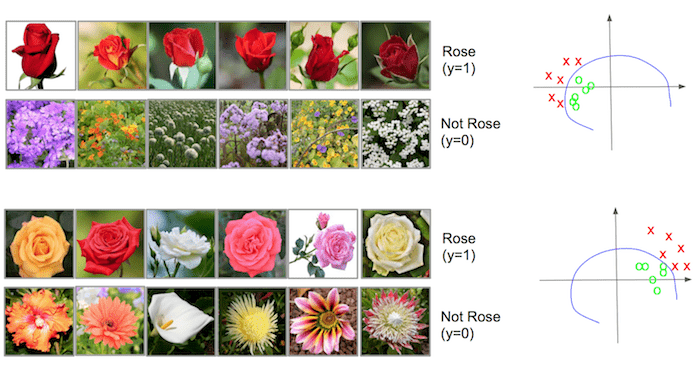
https://learnopencv.com/batch-normalization-in-deep-networks/